In [1]:
import os
import sys
sys.path.append(os.getcwd())
sys.path.insert(0, "../porousequivariantnetworks/code/")
sys.path.insert(0, "../porousequivariantnetworks/")


import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.ticker as tick

from tqdm import tqdm


from models.equivariant_mpnn import MPNN, MPNNPORE
from utils.ZeoliteData import get_zeolite, get_data_pore, get_data_graph, get_data_megnet
from utils.dataloading import get_data, get_graph_data

#import tueplots 

from models.megnet import MEGNet
from models.cgcnn import CGCNN
from models.schnet import SchNet
from models.dimenet import DimeNetPlusPlus as DimeNet

In [3]:
import matplotlib as mpl

In [5]:
plt.rc('font', family='serif',)


In [6]:
from matplotlib import rc

In [7]:
data = get_zeolite('MOR', True)
    
ref = data['ref'] # reflections
tra = data['tra'] # translations
l = data['l'] # scale of the unit cell

# specific for MOR
atoms, hoa, X, A, d, X_pore, A_pore, d_pore, pore = get_data(l, 'MOR')

edges, idx1, idx2, idx2_oh = get_graph_data(A, d)
edges_sp, idx1_sp, idx2_sp, idx2_oh_sp = get_graph_data(A_pore, d_pore)
edges_ps, idx1_ps, idx2_ps, idx2_oh_ps = get_graph_data(A_pore.T, d_pore.T)

In [8]:
_, testloader, trainloader = get_data_pore(atoms, hoa, edges, pore, edges_sp, edges_ps, bs=32, random=True)
_, testloader2, trainloader2 = get_data_graph(atoms, hoa, edges, bs=32, random=True)
_, testloader3, trainloader3 = get_data_megnet(atoms, hoa, edges, bs=32, random=True)

In [9]:
trainX = trainloader.dataset.X.sum((1,2))[:,None].numpy()
trainy = trainloader.dataset.y[:,None].numpy()
testX = testloader.dataset.X.sum((1,2))[:,None].numpy()
testy = testloader.dataset.y[:,None].numpy()

In [11]:
from sklearn.linear_model import LinearRegression as LR

In [12]:
lr = LR()
lr.fit(trainX, trainy)

LinearRegression()

In [13]:
yhat = lr.predict(testX)

In [14]:
yhat.shape, testy.shape

((500, 1), (500, 1))

In [15]:
lr_mse, lr_mae = np.mean((testy - yhat)**2), np.mean(np.abs(testy - yhat))

In [17]:
lr_mse, lr_mae

(6.583005794436996, 1.9449891450851597)

In [18]:
title_size=7.5
label_size=7

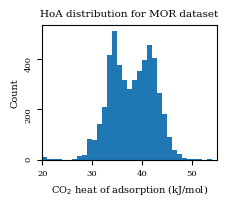

In [19]:
plt.figure(figsize=(2.25,1.75))
plt.hist(hoa, bins=np.arange(20,55,1))
plt.xlabel('CO$_2$ heat of adsorption (kJ/mol)', fontsize=label_size)
plt.ylabel('Count', fontsize=label_size)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6, rotation='vertical')
plt.title('HoA distribution for MOR dataset', fontsize=title_size)
plt.xlim(20,55)
plt.savefig('figures/datadist_mor.pdf', dpi=1200, bbox_inches="tight")
tikzz = plt.xticks()[0]

In [21]:
hoa_x = np.tile(np.linspace(20,55,35)[:,None], (1,12))
hoa_y = np.tile(np.arange(0,12,1)[None], (hoa_x.shape[0],1))


In [24]:
zi = np.zeros((len(hoa_x),12))

for i in range(len(atoms)):
    
    curr_h = hoa[i]
    
    n_als = atoms[i].sum() - 1
    if n_als == -1:
        n_als = 0
              
    for _x in range(0,len(hoa_x)-1):
        
        if hoa_x[_x, n_als] < curr_h <= hoa_x[_x+1, n_als]:
            zi[_x, n_als] += 1

In [26]:
zi = zi/zi.sum(0)[None]

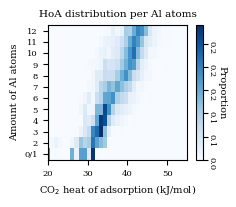

In [27]:
fig, ax = plt.subplots(figsize=(2.25,1.75))
CS = plt.pcolormesh(hoa_x, hoa_y, zi,
                  vmax=zi.max(), vmin=0, cmap='Blues')

plt.xlabel(f"CO$_2$ heat of adsorption (kJ/mol)", fontsize=label_size)
plt.ylabel(f"Amount of Al atoms", fontsize=label_size)
plt.title("HoA distribution per Al atoms", fontsize=title_size)
cbar = plt.colorbar()
plt.yticks(np.arange(0.,12,1), ['0/1'] + np.arange(2,13,1).tolist(), fontsize=6, rotation='horizontal')
plt.xticks(tikzz)
plt.xticks(fontsize=6)
plt.xlim(20,55)
plt.ylim(-0.5,11.5)
cbar.ax.tick_params(labelsize=6, rotation=270,pad=0)
cbar.ax.get_yaxis().labelpad = 8
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.1f'))
cbar.set_label('Proportion', rotation=270, fontsize=label_size)
plt.savefig('figures/aldist_mor.pdf', dpi=1200, bbox_inches="tight")

In [28]:
hoa_x.shape, hoa_y.shape, zi.shape

((35, 12), (35, 12), (35, 12))

In [29]:
mpnn = MPNNPORE(idx1.to('cuda'), idx2.to('cuda'), idx2_oh.to('cuda'), X, X_pore, ref, tra,
                    idx1_sp.to('cuda'), idx2_sp.to('cuda'), idx2_oh_sp.to('cuda'), 
                    idx1_ps.to('cuda'), idx2_ps.to('cuda'), idx2_oh_ps.to('cuda'),
                    hid_size=[8]*6, site_emb_size=8, edge_emb_size=8, mlp_size=24,
                    centers=10, mx_d=6, width=1, pool='sum', pool_pore=True).to('cuda')

mpnn2 = MPNN(idx1.to('cuda'), idx2.to('cuda'), idx2_oh.to('cuda'), X, ref, tra,
                        hid_size=[8]*6, site_emb_size=8, edge_emb_size=8, mlp_size=24,
                        centers=10, mx_d=6, width=1, pool='sum').to('cuda')
meg = MEGNet(idx1, idx2).cuda()

sch = SchNet(d).cuda()

cgcnn = CGCNN(idx1, idx2).cuda()

dimenet = DimeNet(idx1, idx2, torch.tensor(X), torch.tensor(l)).to('cuda')

In [30]:
def get_95_CI(x):
    
    ci = 1.96*np.std(x)/np.sqrt(len(x))
    return ci

In [86]:
for j in (range(1,16)):
    mpnn2.load_state_dict(torch.load(f'model_data_random/MOR/0.75/equi/model_{j}/model.pth'))
    y_pred, y_true = mpnn2.predict(testloader2)

    _mse = ((y_pred - y_true)**2).mean().item()
    _mae = (y_pred - y_true).abs().mean().item()
    print(j, _mae, _mse)

1 1.261289119720459 2.9111549854278564
2 1.336483359336853 2.862061023712158
3 1.2416805028915405 2.816739559173584
4 1.195528507232666 2.6336958408355713
5 1.1962043046951294 2.6345608234405518
6 1.0575580596923828 2.184349298477173
7 1.1695204973220825 2.335430860519409
8 1.1364344358444214 2.4239559173583984
9 1.3874597549438477 3.427615165710449
10 1.0018888711929321 1.9021189212799072
11 1.4962060451507568 3.3357930183410645
12 1.1317267417907715 2.3868486881256104
13 1.2268635034561157 2.8283066749572754
14 1.2028062343597412 2.708359479904175
15 1.0021519660949707 1.762065052986145


In [87]:
props = [0.125, .25, .5, .75, 1.]

mae_p = []
mse_p = []


mae_e = []
mse_e = []

mae_p_ci = []
mse_p_ci = []


mae_e_ci = []
mse_e_ci = []


mae_s = []
mse_s = []

mae_s_ci = []
mse_s_ci = []


for i in props:
    
    _mae_p = []
    _mse_p = []
    _mae_e = []
    _mse_e = []
    _mae_s = []
    _mse_s = []
    
    for j in tqdm(range(1,11)):
    
        mpnn.load_state_dict(torch.load(f'model_data_random/MOR/{i}/pore/model_{j}/model.pth'))
        y_pred, y_true = mpnn.predict(testloader)

        _mse = ((y_pred - y_true)**2).mean().item()
        _mae = (y_pred - y_true).abs().mean().item()

        _mae_p.append(_mae)
        _mse_p.append(_mse)

        mpnn2.load_state_dict(torch.load(f'model_data_random/MOR/{i}/equi/model_{j}/model.pth'))
        y_pred, y_true = mpnn2.predict(testloader2)

        _mse = ((y_pred - y_true)**2).mean().item()
        _mae = (y_pred - y_true).abs().mean().item()

        _mae_e.append(_mae)
        _mse_e.append(_mse)
    
    
        sch.load_state_dict(torch.load(f'model_data_random/MOR/{i}/schnet/model_{j}/model.pth'))
        y_pred, y_true = sch.predict(testloader2)

        _mse = ((y_pred - y_true)**2).mean().item()
        _mae = (y_pred - y_true).abs().mean().item()

        _mae_s.append(_mae)
        _mse_s.append(_mse)
    
    mae_p.append(np.mean(_mae_p))
    mse_p.append(np.mean(_mse_p))
    mae_e.append(np.mean(_mae_e))
    mse_e.append(np.mean(_mse_e))
    mae_s.append(np.mean(_mae_s))
    mse_s.append(np.mean(_mse_s))

    
    mae_p_ci.append(get_95_CI(_mae_p))
    mse_p_ci.append(get_95_CI(_mse_p))
    mae_e_ci.append(get_95_CI(_mae_e))
    mse_e_ci.append(get_95_CI(_mse_e))
    mae_s_ci.append(get_95_CI(_mae_s))
    mse_s_ci.append(get_95_CI(_mse_s))

    print(i)
    

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.46s/it]


0.125


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.46s/it]


0.25


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.44s/it]


0.5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.45s/it]


0.75


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.46s/it]

1.0


In [88]:
mae_meg = []
mse_meg = []

mae_cg = []
mse_cg = []

mae_dn = []
mse_dn = []

for j in range(1,11):
    
   

    meg.load_state_dict(torch.load(f'model_data_random/MOR/1.0/megnet/model_{j}/model.pth'))
    y_pred, y_true = meg.predict(testloader3)

    _mse = ((y_pred - y_true)**2).mean().item()
    _mae = (y_pred - y_true).abs().mean().item()

    mae_meg.append(_mae)
    mse_meg.append(_mse)
    
    
    cgcnn.load_state_dict(torch.load(f'model_data_random/MOR/1.0/cgcnn/model_{j}/model.pth'))
    y_pred, y_true = cgcnn.predict(testloader2)

    _mse = ((y_pred - y_true)**2).mean().item()
    _mae = (y_pred - y_true).abs().mean().item()

    mae_cg.append(_mae)
    mse_cg.append(_mse)

    dimenet.load_state_dict(torch.load(f'model_data_random/MOR/1.0/dime/model_{j}/model.pth'))
    y_pred, y_true = dimenet.predict(testloader2)

    _mse = ((y_pred - y_true)**2).mean().item()
    _mae = (y_pred - y_true).abs().mean().item()

    mae_dn.append(_mae)
    mse_dn.append(_mse)
    
    
    print(j)
    

1
2
3
4
5
6
7
8
9
10


In [89]:
maes = [mae_dn, mae_cg, mae_meg, _mae_s, _mae_e, _mae_p]
mses = [mse_dn, mse_cg, mse_meg, _mse_s, _mse_e, _mse_p]

In [90]:
df = pd.DataFrame(columns = ['MAE','MSE'], index=['Linear Regression','DimeNet++','CGCNN','MEGNet', 'SchNet','Ours (without pores)', 'Ours (with pores)'])
for i in range(len(df.index)):

    if i == 0:
        a = np.round(lr_mae, 3)
        s = np.round(lr_mse, 3)
    else:
        mu_a = np.mean(maes[i-1]).round(3)
        mu_s = np.mean(mses[i-1]).round(3)
        
        ci_a = get_95_CI(maes[i-1]).round(3)
        ci_s = get_95_CI(mses[i-1]).round(3)
        
        
        a = fr'{mu_a} $$\pm$$ {ci_a}'
        s = fr'{mu_s} $$\pm$$ {ci_s}'
        
    df.loc[df.index[i]] = [a,s]

In [91]:
df

,MAE,MSE
Linear Regression,1.945,6.583
DimeNet++,1.696 $$\pm$$ 0.09,5.132 $$\pm$$ 0.46
CGCNN,1.673 $$\pm$$ 0.087,4.822 $$\pm$$ 0.422
MEGNet,1.529 $$\pm$$ 0.077,4.238 $$\pm$$ 0.433
SchNet,1.046 $$\pm$$ 0.015,2.041 $$\pm$$ 0.084
Ours (without pores),1.05 $$\pm$$ 0.049,2.01 $$\pm$$ 0.169
Ours (with pores),0.877 $$\pm$$ 0.018,1.488 $$\pm$$ 0.05


In [92]:
print(df.to_latex(escape=False))

\begin{tabular}{lll}
\toprule
 & MAE & MSE \\
\midrule
Linear Regression & 1.945000 & 6.583000 \\
DimeNet++ & 1.696 $$\pm$$ 0.09 & 5.132 $$\pm$$ 0.46 \\
CGCNN & 1.673 $$\pm$$ 0.087 & 4.822 $$\pm$$ 0.422 \\
MEGNet & 1.529 $$\pm$$ 0.077 & 4.238 $$\pm$$ 0.433 \\
SchNet & 1.046 $$\pm$$ 0.015 & 2.041 $$\pm$$ 0.084 \\
Ours (without pores) & 1.05 $$\pm$$ 0.049 & 2.01 $$\pm$$ 0.169 \\
Ours (with pores) & 0.877 $$\pm$$ 0.018 & 1.488 $$\pm$$ 0.05 \\
\bottomrule
\end{tabular}



In [93]:
mae_p = np.array(mae_p)
mse_p = np.array(mse_p)
mae_e = np.array(mae_e)
mse_e = np.array(mse_e)
mae_s = np.array(mae_s)
mse_s = np.array(mse_s)

mae_p_ci = np.array(mae_p_ci)
mse_p_ci = np.array(mse_p_ci)
mae_e_ci = np.array(mae_e_ci)
mse_e_ci = np.array(mse_e_ci)
mae_s_ci = np.array(mae_s_ci)
mse_s_ci = np.array(mse_s_ci)

In [94]:
props2 = np.array(props)*len(trainloader.dataset)

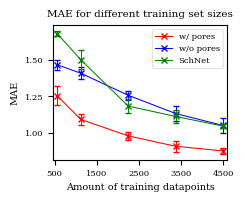

In [95]:
plt.figure(figsize=(2.25,1.75))
plt.plot(props2, mae_p, c='red', label = 'w/ pores', marker='x', markersize=3.75, lw=.75)
plt.errorbar(props2, mae_p, mae_p_ci, c='red', capsize=2.5, fmt='none', lw=.75)
plt.plot(props2, mae_e, c='blue', label = 'w/o pores', marker='x', markersize=3.75, lw=.75)
plt.errorbar(props2, mae_e, mae_e_ci, c ='blue', capsize=2.5, fmt='none', lw=.75)
plt.plot(props2, mae_s, c='green', label = 'SchNet', marker='x', markersize=3.75, lw=.75)
plt.errorbar(props2, mae_s, mae_s_ci,c='green', capsize=2.5, fmt='none', lw=.75)

plt.xlabel('Amount of training datapoints', fontsize=label_size)
plt.ylabel('MAE', fontsize=label_size)
plt.title('MAE for different training set sizes', fontsize=title_size)
plt.legend(fontsize=6, loc='upper right', framealpha=0.5)
plt.xticks(np.arange(500, 5000, 1000), fontsize=6)
plt.yticks(fontsize=6)
plt.xlim(props2.min()-100, props2.max()+100)
plt.savefig('figures/mae2_mor_int.pdf', dpi=1200, bbox_inches = "tight")

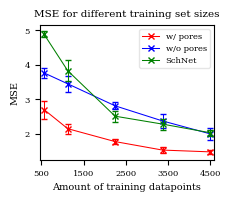

In [96]:
plt.figure(figsize=(2.25,1.75))
plt.plot(props2, mse_p, c='red', label = 'w/ pores', marker='x', markersize=3.75, lw=.75)
plt.errorbar(props2, mse_p, mse_p_ci, c='red', capsize=2.5, fmt='none', lw=.75)
plt.plot(props2, mse_e, c='blue', label = 'w/o pores', marker='x', markersize=3.75, lw=.75)
plt.errorbar(props2, mse_e, mse_e_ci, c ='blue', capsize=2.5, fmt='none', lw=.75)
plt.plot(props2, mse_s, c='green', label = 'SchNet', marker='x', markersize=3.75, lw=.75)
plt.errorbar(props2, mse_s, mse_s_ci,c='green', capsize=2.5, fmt='none', lw=.75)

plt.xlabel('Amount of training datapoints', fontsize=label_size)
plt.ylabel('MSE', fontsize=label_size)
plt.title('MSE for different training set sizes', fontsize=title_size)
plt.legend(fontsize=6, loc='upper right', framealpha=0.5)
plt.xticks(np.arange(500, 5000, 1000), fontsize=6)
plt.yticks(fontsize=6)
plt.xlim(props2.min()-100, props2.max()+100)
plt.savefig('figures/mse2_mor_int.pdf', dpi=1200, bbox_inches = "tight")

In [97]:
best_idx = np.argmin(_mae_p)
mpnn.load_state_dict(torch.load(f'model_data_random/MOR/1.0/pore/model_{best_idx+1}/model.pth'))
y_pred, y_true = mpnn.predict(testloader)

In [98]:
from scipy.interpolate import griddata

In [99]:
y_pred.min(), y_pred.max(), y_true.min(), y_true.max()

(tensor(20.1836), tensor(47.5723), tensor(20.8601), tensor(48.3556))

In [100]:
Z = torch.ones_like(y_pred)

In [113]:
nn = 60
xmin = 25
xmax = 50
xi = np.linspace(xmin, xmax, nn)
yi = np.linspace(xmin, xmax, nn)

In [114]:
#xi.shape, yi.shape, xi, yi

In [115]:
zi = np.zeros((nn,nn))

for i in range(len(y_pred)):
    
    curr_p = y_pred[i].item()
    curr_t = y_true[i].item()
    
    for _x in range(0,nn-1):
        
        if xi[_x] < curr_p <= xi[_x+1]:
            
            for _y in range(0,nn-1):
                
                if yi[_y] < curr_t <= xi[_y+1]:
                    
                    zi[_x,_y] += 1

In [116]:
n_colors = int(zi.max())

C:\Users\20175552\AppData\Local\Temp\ipykernel_15576\1783921490.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues', n_colors+1)


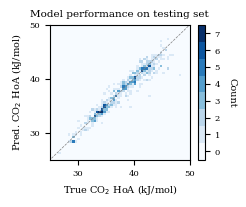

In [120]:
fig, ax = plt.subplots(figsize=(2.25,1.75))
cmap = plt.cm.get_cmap('Blues', n_colors+1)
CS = plt.pcolormesh(xi, yi, zi,
                  vmax=zi.max(), vmin=0, cmap=cmap)
plt.xlabel(f"True CO$_2$ HoA (kJ/mol)", fontsize=label_size)
plt.ylabel(f"Pred. CO$_2$ HoA (kJ/mol)", fontsize=label_size)
plt.title("Model performance on testing set", fontsize=title_size)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".5", lw=.5)
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 12
cbar.set_label('Count', rotation=270, fontsize=label_size)
cbar.ax.get_yaxis().set_ticks(np.arange(n_colors/(2*(n_colors+1)), n_colors, n_colors/(n_colors+1)), np.arange(n_colors+1) )
cbar.ax.tick_params(labelsize=6)
plt.xticks(plt.yticks()[0])
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)

#plt.savefig('figures/truepred.svg', dpi=1200, bbox_inches="tight")
plt.savefig('figures/truepred_mor_int.pdf', dpi=1200, bbox_inches="tight")